In [1]:
import sys
import os
os.environ['BACKEND'] = 'numpy'


import numpy as np
import pandas as pd 
import numba
from numba import njit, prange
import time

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..', '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import get_global_logger, Array
from QES.general_python.common import Plotter, MatrixPrinter, colorsCycle, linestylesCycle
from QES.general_python.common import Directories
# from QES.general_python.common.hdf5_lib import HDF5Handler, read_hdf5_extract_and_concat_list
from QES.general_python.common.hdf5man import HDF5Manager
from QES.general_python.maths.statistics import HistogramAverage, Fraction

# ------------------------------------------------------------------
from QES.Algebra.Model.Interacting.Spin.ultrametric import UltrametricModel
from QES.Algebra.hilbert import HilbertSpace

# ------------------------------------------------------------------
from QES.Algebra.Properties import time_evo
from QES.Algebra.Properties import statistical
from QES.general_python.algebra.linalg import act, overlap, overlap_diag

# ------------------------------------------------------------------
import QES.Algebra.Operator.operators_spin as op_spin

logger      = get_global_logger()

# ------------------------------------------------------------------
data_dir = Directories(os.curdir, 'data_add')
data_dir.mkdir()


23_05_2025_08-57_49 [INFO] Log file created: ./log/QES_23_05_2025_08-57_49.log
23_05_2025_08-57_49 [INFO] Log level set to: info
23_05_2025_08-57_49 [INFO] ############Global logger initialized.############
23_05_2025_08-57_49 [INFO] JAX is not available. Using NumPy as the active backend.
23_05_2025_08-57_49 [INFO] **************************************************
23_05_2025_08-57_49 [INFO] Backend Configuration:
23_05_2025_08-57_49 [INFO] 		NumPy Version: 1.26.4
23_05_2025_08-57_49 [INFO] 		SciPy Version: 1.13.1
23_05_2025_08-57_49 [INFO] 		JAX Version: Not Available
23_05_2025_08-57_49 [INFO] 		Active Backend: numpy
23_05_2025_08-57_49 [INFO] 			JAX Available: False
23_05_2025_08-57_49 [INFO] 			Default Seed: 42
23_05_2025_08-57_49 [INFO] 		NumPy Backend Details:
23_05_2025_08-57_49 [INFO] 				Main Module: numpy
23_05_2025_08-57_49 [INFO] 				Random Module: Generator
23_05_2025_08-57_49 [INFO] 				SciPy Module: scipy
23_05_2025_08-57_49 [INFO] 		Active Data Types:
23_05_2025_08-57_

Directories(PosixPath('data_add'))

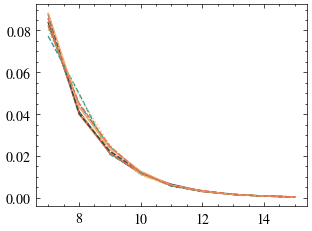

In [2]:
rng                 = np.random.default_rng()
rand_num            = rng.integers(0, int(1e5))

bw_df               = pd.read_csv("bw.csv", index_col=0, header=None, dtype=float)
mls_df              = pd.read_csv("mls.csv", index_col=0, header=None, dtype=float)
bw_df.index         = [f'{x:.2f}' for x in bw_df.index]
mls_df.index        = [f'{x:.2f}' for x in mls_df.index]
bw_df.columns       = list(range(7, 17))
mls_df.columns      = list(range(7, 16))

for i in range(len(bw_df.columns)):
    mls_df.iloc[i].plot(label=f'{bw_df.index[i]}', linestyle=next(linestylesCycle))


In [3]:


def remove_moving_average(data: np.ndarray, window: int) -> np.ndarray:
    """
    Subtract from each row of `data` its causal moving average of length `window`.

    Let
      data[i, t] ∈ ℝ,
    and define the cumulative sum for each row:
      C[i, t] = ∑_{k=0}^t data[i, k].
    Then the causal moving average is
      m[i, t] = 
         C[i, t] / (t+1),        for t < window,
        (C[i, t] − C[i, t−window]) / window,  otherwise.
    We return
      residual[i, t] = data[i, t] − m[i, t].

    Parameters
    ----------
    data : np.ndarray, shape (N, T)
        N realizations (rows) of length-T time series.
    window : int
        Width of the causal moving‐average window.

    Returns
    -------
    residual : np.ndarray, shape (N, T)
        Original data with its moving average removed, per row.
    """
    N, T      = data.shape
    cumsum    = np.cumsum(data, axis=1)      # shape (N, T)
    residual  = np.empty_like(data, dtype=float)

    # first `window` points use growing denominator (1,2,…,window)
    t0        = min(window, T)
    counts    = np.arange(1, t0+1)           # [1, 2, …, t0]
    residual[:, :t0] = data[:, :t0] - cumsum[:, :t0] / counts

    # remaining points use fixed window
    if T > window:
        numer = cumsum[:, window:] - cumsum[:, :-window]
        ma    = numer / window
        residual[:, window:] = data[:, window:] - ma

    return residual

@staticmethod
def get_cdf(x, y, gammaval = 0.5, BINVAL = 21):
    """
    Calculate the cumulative distribution function (CDF) and find the gamma value.

    Parameters:
    x (array-like): The independent variable values.
    y (array-like): The dependent variable values, which may contain NaNs.
    gammaval (float, optional): The target CDF value to find the corresponding gamma value. Default is 0.5.

    Returns:
    tuple: A tuple containing:
        - x (array-like): The input independent variable values.
        - y (array-like): The input dependent variable values with NaNs removed.
        - cdf (array-like): The cumulative distribution function values.
        - gammaf (float): The value of the independent variable corresponding to the target CDF value.
    """
    # Apply the moving average to smooth y
    y_smoothed  = np.convolve(y, np.ones(BINVAL)/BINVAL, mode='same')
    cdf         = np.cumsum(y_smoothed * np.diff(np.insert(x, 0, 0)))
    cdf         /= cdf[-1]
    y_smoothed  /= cdf[-1]
    gammaf      = x[np.argmin(np.abs(cdf - gammaval))]
    return x, y_smoothed, cdf, gammaf


In [6]:
import matplotlib.pyplot as plt
colors_map, norm, cmap = Plotter.get_colormap(np.arange(8, 15, dtype = int), 'viridis_r')

def get_results_single(direct   : Directories, 
                        alpha   : float,
                        ns      : int,
                        n       : int,
                        uniform : bool = False,
                        operator: str  = 'Sz/0'
                        ):
    logger.info(f"alpha: {alpha:.2f}, ns: {ns}, n: {n}, uniform: {uniform}, operator: {operator}", color='red')
    fig, ax         = Plotter.get_subplots(nrows = 1, ncols = 5, figsize = (15, 3), dpi = 150)
    fig.suptitle(f"$\\alpha={alpha:.2f}, L={ns-n}$")
    
    color_ns        = colors_map(ns)
    mean_lvl        = mls_df.loc[f'{alpha:.2f}', ns]
    mean_lvl_lim    = mean_lvl / 50
    logger.info(f"mean level: {mean_lvl}", lvl = 2)

    hist_key        = f'/historgram/{operator}/average/values'
    hist_typ_key    = f'/historgram/{operator}/typical/values'
    hist_count_key  = '/historgram/counts'
    hist_edges_key  = '/historgram/edges'
    energy_key      = '/energies'
    ldos_key        = '/ldos'
    time_key        = '/time'
    time_evo_key    = f'/time_evolution/{operator}/expectation'
    time_evo_d_key  = f'/time_evolution/{operator}/diag_ens'
    hilbert_dim     = 2**ns
    #! -------------------------------------------------------
    model = UltrametricModel(
        ns      = ns,
        n       = n,
        alphas  = alpha
    )
    direct_in   = Directories(os.path.abspath(direct), 'uniform' if uniform else 'log', str(model))
    filelist    = direct_in.list_files(filters = [lambda x: str(x).endswith('h5')])
    if len(filelist) == 0:
        logger.warning(f"Files not found in {direct_in}")
        return None

    filelist        = [str(x) for x in filelist]
    filelist_stat   = [x for x in filelist if 'stat_' in x  ]
    filelist_evo    = [x for x in filelist if 'evo_'  in x  ]
    filelist_diag   = [x for x in filelist if 'dia_'  in x  ]
    filelist_hist   = [x for x in filelist if 'hist_' in x  ]
    
    # --------------------------------------------------------
    #! energy
    data_energy             = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_stat, dataset_keys=[energy_key])
    data_energy             = np.array([x[energy_key] for x in data_energy])
    data_energy             = data_energy.reshape(-1, data_energy.shape[-1], order='C')
    mean_lvl_spacing        = np.mean(np.mean(np.diff(data_energy, axis=1), axis = 1), axis=0)
    bandwidth_data          = np.mean(np.var(data_energy, axis=1), axis=0)
    Plotter.vline(ax[0], mean_lvl_spacing, label=r'$\Delta$', ls='--', color = 'black')
    Plotter.vline(ax[2], mean_lvl_spacing, label=r'$\Delta$', ls='--', color = 'black')
    Plotter.vline(ax[3], mean_lvl_spacing, label=r'$\Delta$', ls='--', color = 'black')
    logger.info(f"mean level spacing true: {mean_lvl_spacing}", lvl = 2)
    
    # --------------------------------------------------------
    #! histogram
    data_hist_bins          = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_edges_key])
    data_hist_bins          = np.mean([x[hist_edges_key] for x in data_hist_bins], axis=0)
    data_hist_av            = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_key])
    data_hist_av            = np.mean([x[hist_key] for x in data_hist_av], axis=0)
    # data_hist_av            = data_hist_av / np.trapz(data_hist_av, x=data_hist_bins)
    data_hist_typ           = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_typ_key])
    data_hist_typ           = np.mean([(x[hist_typ_key]) for x in data_hist_typ], axis=0)
    # data_hist_typ           = data_hist_typ / np.trapz(data_hist_typ, x=data_hist_bins)
    data_hist_count         = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_count_key])
    data_hist_count         = np.mean([x[hist_count_key] for x in data_hist_count], axis=0)

    # omegas2, y_smoothed2, cdf2, gammaf2 = get_cdf(data_hist_bins, data_hist_typ, BINVAL=21)
    # ax[0].stairs(data_hist_typ[1:], data_hist_bins, label=r'typ[$O^2(\omega)$]', ls=next(linestylesCycle), color = 'purple')
    omegas, y_smoothed, cdf, gammaf = get_cdf(data_hist_bins, data_hist_av, BINVAL=21)
    ax[0].stairs(data_hist_av[1:], data_hist_bins, label=r'$O^2(\omega)$', ls=next(linestylesCycle), color = 'red')
    Plotter.vline(ax[0], gammaf, label=r'$\Gamma$', ls='--', color = 'green', lw = 1.5)
    Plotter.plot(ax[3], omegas, y_smoothed, label=r'$O^2(\omega)$', ls='--', color = 'red')
    
    #! twinax
    ax3_twiny = ax[3].twinx()
    ax3_twiny.set_ylim(0, 1)
    Plotter.plot(ax3_twiny, omegas, cdf, label=r'$cdf[O^2(\omega)]$', ls=next(linestylesCycle), color = 'blue')
    # Plotter.set_ax_params(ax3_twiny, xlabel=r'$\omega$', ylabel=r'$cdf[O^2(\omega)]$', xscale='log', yscale='linear', xlim=(mean_lvl_lim, None), ylim=(0, 1))
    
    # ax[3].plot(omegas2, y_smoothed2, label=r'typ[$O^2(\omega)$]', ls=next(linestylesCycle), color = 'purple')
    ax[2].axvline(gammaf, label=r'$\Gamma$', ls='--', color = 'green')
    ax[3].axvline(gammaf, label=r'$\Gamma$', ls='--', color = 'green')
    
    # --------------------------------------------------------
    #! time evolution
    data_evo_time           = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_evo, dataset_keys=[time_key])
    data_evo_time           = np.array([x[time_key] for x in data_evo_time])[0]
    
    data_evo_av             = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_evo, dataset_keys=[time_evo_key])
    data_evo_av             = np.array([x[time_evo_key] for x in data_evo_av])
    data_evo_av             = data_evo_av.reshape(-1, data_evo_av.shape[-1], order='C')
    data_evo_d_av           = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_evo, dataset_keys=[time_evo_d_key])
    data_evo_d_av           = np.array([np.array(x[time_evo_d_key]) for x in data_evo_d_av]).flatten()
    data_evo_av             = data_evo_av - data_evo_d_av[:, np.newaxis]
    Plotter.plot(ax[1], data_evo_time, np.mean(data_evo_av, axis = 0) + 1, label=r'$\tilde{C}(t) + 1$', color = color_ns)

    # remove structure
    data_evo_av_rm          = remove_moving_average(data_evo_av, window=31)
    distr, distr_bins       = np.histogram(data_evo_av_rm, bins=100, density=True)
    distr_bins              = 0.5 * (distr_bins[1:] + distr_bins[:-1])
    Plotter.plot(ax[1], data_evo_time, np.mean(data_evo_av_rm, axis = 0) + 1, label=r'$\tilde{C}(t)_{\rm MA} + 1$', color = 'black')
    Plotter.plot(ax[4], distr_bins, distr, label=r'$P(\tilde{C}(t))$', ls=next(linestylesCycle), color = color_ns)
    
    # bandwidth_data          = bw_df.loc[f'{alpha:.2f}', ns]
    # time_delta              = 2.0 * np.pi / bandwidth_data
    time_delta              = data_evo_time[1] - data_evo_time[0]
    time_num                = data_evo_time.shape[0]
    # time_norm       = 2 / np.sqrt(time_num)
    time_norm               = 2 / np.sqrt(time_num)
    data_evo_fft_om         = np.fft.fftfreq(time_num, d=time_delta)[1:time_num//2] * 2 * np.pi
    data_evo_fft_base       = np.fft.fft(data_evo_av, axis=1)[:, 1:time_num//2] * time_norm
    data_evo_fft            = np.abs(data_evo_fft_base)**2 / data_evo_time.shape[0]**2
    data_evo_fft            = np.mean(data_evo_fft, axis = 0)
    data_evo_fft_n          = np.trapz(data_evo_fft, x=data_evo_fft_om, axis=0)
    data_evo_fft            = data_evo_fft / data_evo_fft_n
    
    logger.info(f"bw: {bandwidth_data}, time delta: {time_delta}, time num: {time_num}, shape: {data_evo_fft_om.shape}", lvl = 2)
    logger.info(f"data_evo_fft shape: {data_evo_fft.shape}", lvl = 3, color = 'blue')
    Plotter.plot(ax[0], data_evo_fft_om, data_evo_fft, label=r'$\tilde{S}(\omega)$', ls='-', color = color_ns)
    Plotter.plot(ax[2], data_evo_fft_om, data_evo_fft, label=r'$\tilde{S}(\omega)$', ls='-', color = color_ns)

    # --------------------------------------------------------
    #! energy
    data_ldos               = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_stat, dataset_keys=['/ldos'])
    data_ldos               = np.array([x[ldos_key] for x in data_ldos])
    data_ldos               = data_ldos.reshape(-1, data_ldos.shape[-1], order='C')
    
    k_function_list         = [statistical.k_function(data_ldos[i], data_energy[i], data_hist_bins, np.mean(data_energy[i])) for i in range(len(data_energy))]
    k_functions             = np.array([x[0] for x in k_function_list])
    k_counts                = np.array([x[1] for x in k_function_list])
    k_counts[k_counts == 0] = 1
    k_functions             = (k_functions / k_counts)
    k_functions             = np.mean(k_functions, axis=0)
    # k_functions             = k_functions / np.trapz(k_functions, x=data_hist_bins[1:])
    ax[0].stairs(k_functions, data_hist_bins, label=r'$K(\omega)$', linestyle=":", color = 'black')
    
    # multiply k and histograms together
    k_times_hist            = k_functions * data_hist_av[1:]
    k_times_hist_norm       = np.trapz(k_times_hist, x=data_hist_bins[1:])
    k_times_hist           /= k_times_hist_norm
    ax[2].stairs(k_times_hist, data_hist_bins, label=r'$K(\omega) \cdot O^2(\omega)$', ls='--', color = 'black', lw = 1.5)

    #! -------------------------------------------------------
    Plotter.set_ax_params(ax[0], xlabel=r'$\omega$', ylabel=r'$\tilde{S}(\omega)$', xscale='log', yscale='log', xlim=(mean_lvl_lim, 1e1))
    Plotter.set_ax_params(ax[1], xlabel=r'$t$', ylabel=r'$(C(t)-C_{\rm diag}) + 1$', xscale='log', yscale='log')
    Plotter.set_ax_params(ax[2], xlabel=r'$\omega$', ylabel=r'$K(\omega) O^2(\omega)$', xscale='log', yscale='log', xlim=(mean_lvl_lim, 1e1))
    Plotter.set_ax_params(ax[3], xlabel=r'$\omega$', ylabel=r'$cdf[O^2(\omega)]$', xscale='log', yscale='log', xlim=(mean_lvl_lim, 1e1))
    Plotter.set_ax_params(ax[4], xlabel=r'$\tilde{C}(t)$', ylabel=r'$P(\tilde{C}(t))$', xscale='linear', yscale='log')
    for axis in ax:
        Plotter.set_legend(axis, framealpha=0.5, fontsize=8, frameon=True)
        Plotter.set_tickparams(axis)
        if axis != ax[1] and axis != ax[4]:
            axis.set_xlim(mean_lvl_lim, 1e1)
        axis.grid()
        
    fig.tight_layout()
    return {
        'k/base'            : k_functions * k_functions[0],
        'kO2/av'            : k_times_hist,
        'kO2/integral'      : k_times_hist_norm,
        'k02/omegas'        : data_hist_bins,
        'O2/av'             : data_hist_av,
        'O2/av_smooth'      : y_smoothed,
        'O2/typ'            : data_hist_typ,
        'O2/count'          : data_hist_count,
        'O2/cdf'            : cdf,
        'O2/omegas'         : omegas,
        'evo/time'          : data_evo_time,
        'evo/de'            : data_evo_d_av,
        'evo/av'            : data_evo_av,
        'evo/moving_av_rm'  : np.mean(data_evo_av_rm, axis = 0),
        'fft/s'             : data_evo_fft,
        'fft/integral'      : data_evo_fft_n,
        'fft/om'            : data_evo_fft_om,
        'stat/gamma_th'     : gammaf,
        'stat/mean_lvl'     : mean_lvl_spacing,
        'stat/bw'           : bandwidth_data,
        'stat/var'          : np.mean(np.var(data_energy, axis=1), axis=0),
    }

23_05_2025_09-15_08 [INFO] alpha: 0.62, ns: 8, n: 1, uniform: True, operator: Sz/0
23_05_2025_09-15_08 [INFO] 		->mean level: 0.049914282
23_05_2025_09-15_08 [INFO] 		->mean level spacing true: 0.02414666144695907
23_05_2025_09-15_09 [INFO] 		->bw: 1.624936393743701, time delta: 0.49365747414131245, time num: 40000, shape: (19999,)
23_05_2025_09-15_09 [INFO] 			->data_evo_fft shape: (19999,)
23_05_2025_09-15_13 [INFO] alpha: 0.62, ns: 9, n: 1, uniform: True, operator: Sz/0
23_05_2025_09-15_14 [INFO] 		->mean level: 0.02078337
23_05_2025_09-15_14 [INFO] 		->mean level spacing true: 0.012813458873165935
23_05_2025_09-15_14 [INFO] 		->bw: 1.6188451385113005, time delta: 0.5916349848854447, time num: 40000, shape: (19999,)
23_05_2025_09-15_14 [INFO] 			->data_evo_fft shape: (19999,)
23_05_2025_09-15_18 [INFO] alpha: 0.62, ns: 10, n: 1, uniform: True, operator: Sz/0
23_05_2025_09-15_18 [INFO] 		->mean level: 0.012164812
23_05_2025_09-15_18 [INFO] 		->mean level spacing true: 0.0067521067624

/home/klimak/Codes/QuantumEigenSolver/Python/QES/general_python/common/plot.py:1754: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  return plt.subplots(nrows, ncols, **kwargs)


23_05_2025_09-17_20 [INFO] alpha: 0.98, ns: 8, n: 1, uniform: True, operator: Sz/0
23_05_2025_09-17_21 [INFO] 		->mean level: 0.04508737
23_05_2025_09-17_21 [INFO] 		->mean level spacing true: 0.04294854934260402
23_05_2025_09-17_21 [INFO] 		->bw: 6.971244931496435, time delta: 0.546506887041829, time num: 40000, shape: (19999,)
23_05_2025_09-17_21 [INFO] 			->data_evo_fft shape: (19999,)
23_05_2025_09-17_24 [INFO] alpha: 0.98, ns: 9, n: 1, uniform: True, operator: Sz/0
23_05_2025_09-17_24 [INFO] 		->mean level: 0.02479629
23_05_2025_09-17_24 [INFO] 		->mean level spacing true: 0.022783494588257198
23_05_2025_09-17_25 [INFO] 		->bw: 7.695253238803308, time delta: 0.49588745962389336, time num: 40000, shape: (19999,)
23_05_2025_09-17_25 [INFO] 			->data_evo_fft shape: (19999,)
23_05_2025_09-17_29 [INFO] alpha: 0.98, ns: 10, n: 1, uniform: True, operator: Sz/0
23_05_2025_09-17_29 [INFO] 		->mean level: 0.012533867
23_05_2025_09-17_29 [INFO] 		->mean level spacing true: 0.0120131008848687

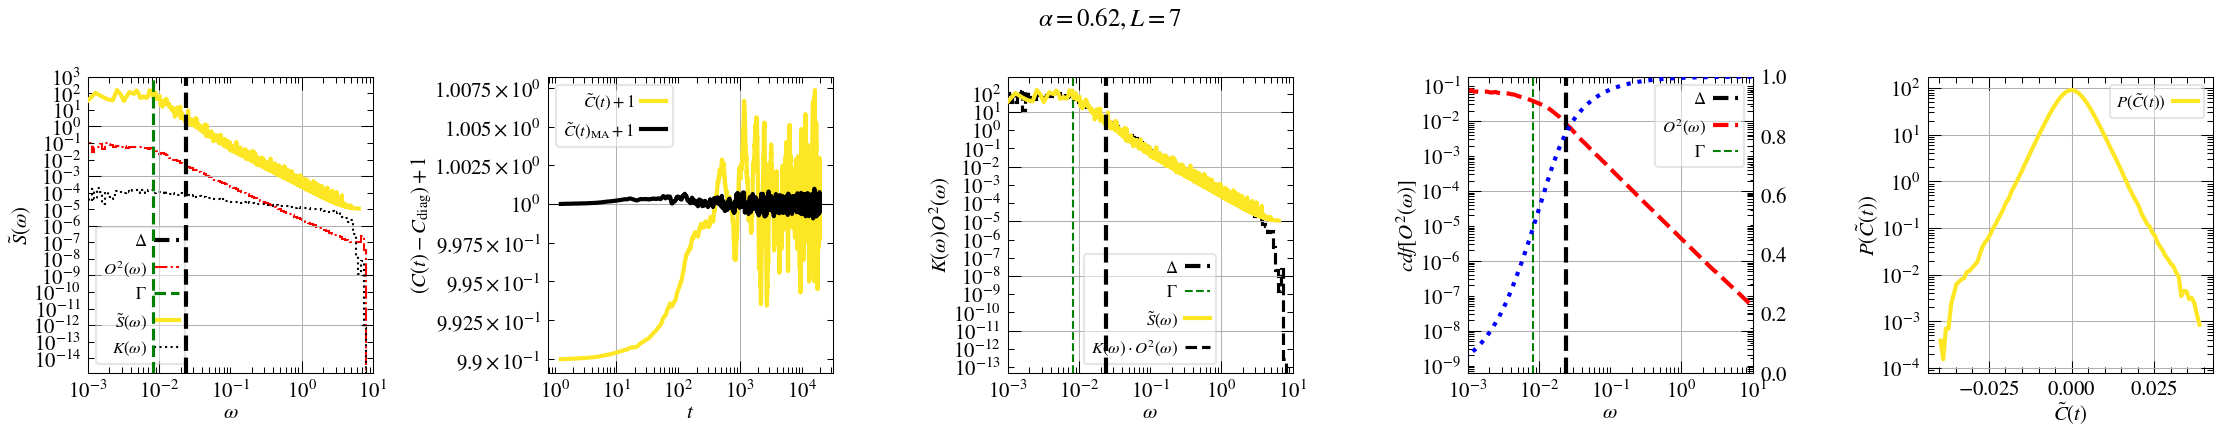

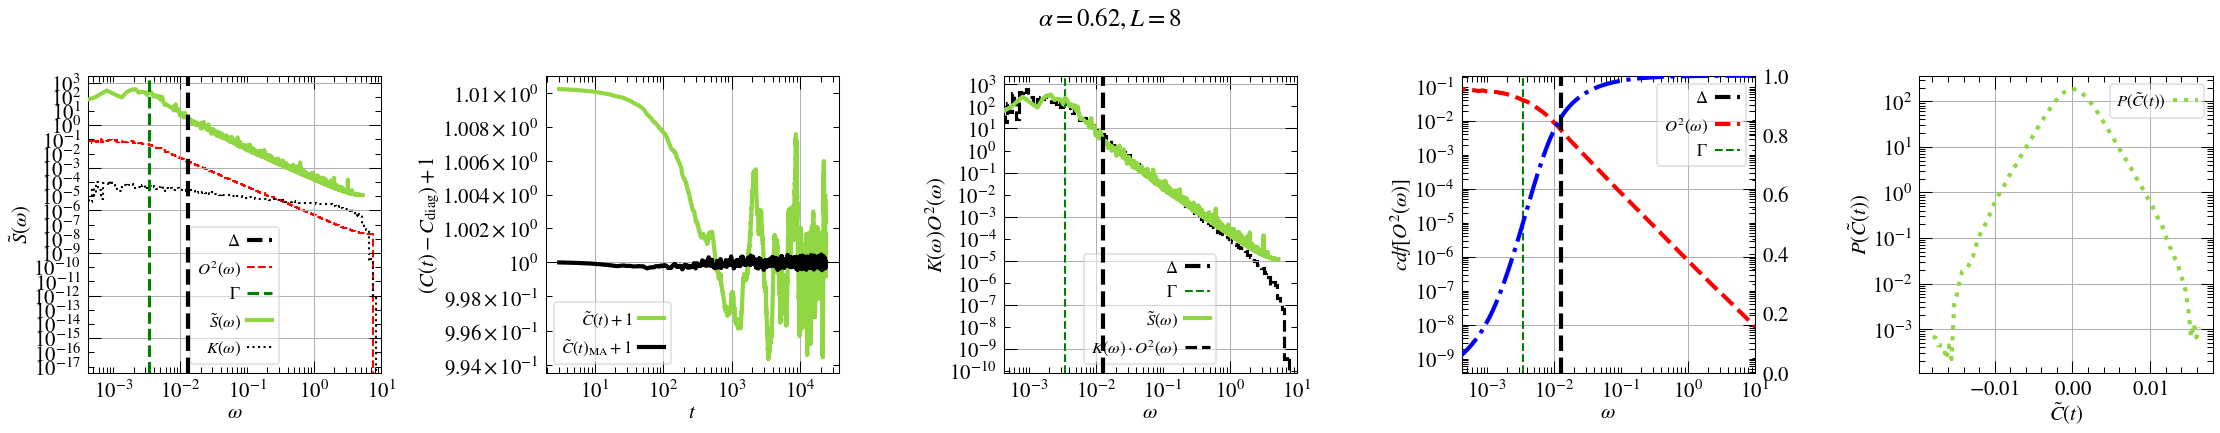

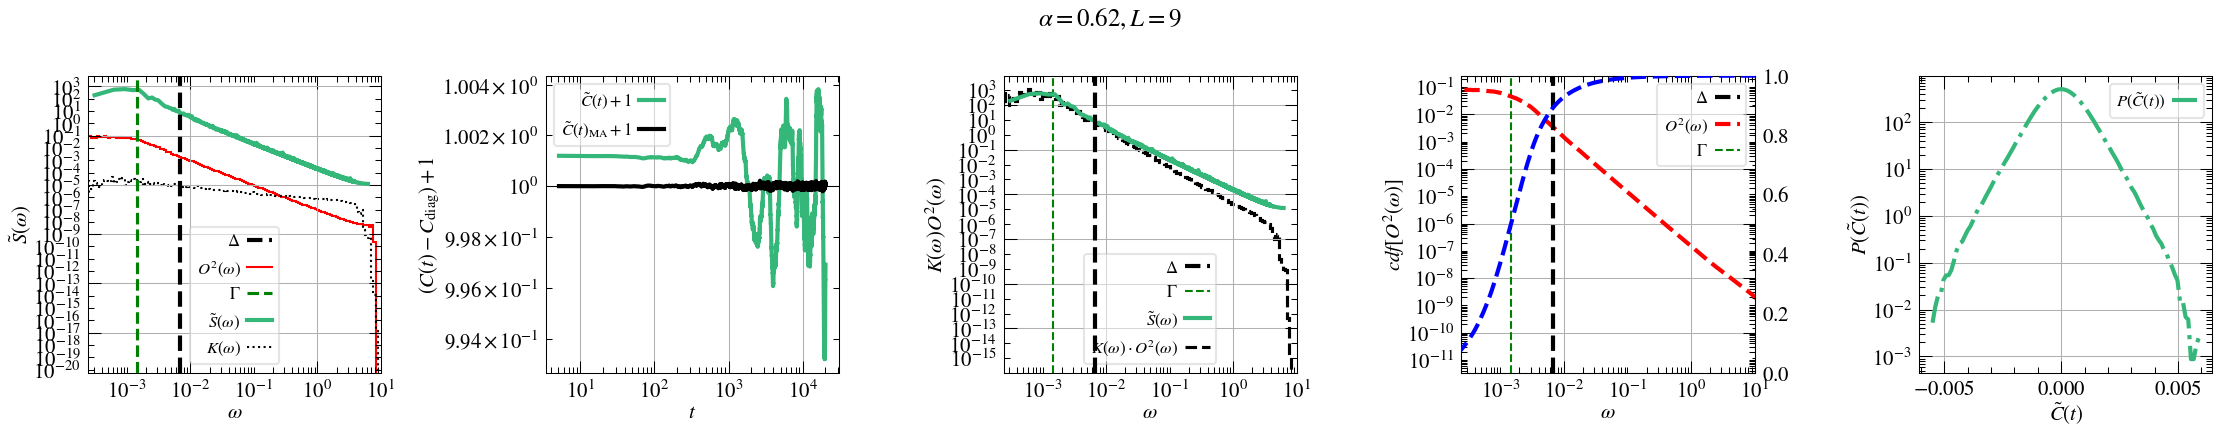

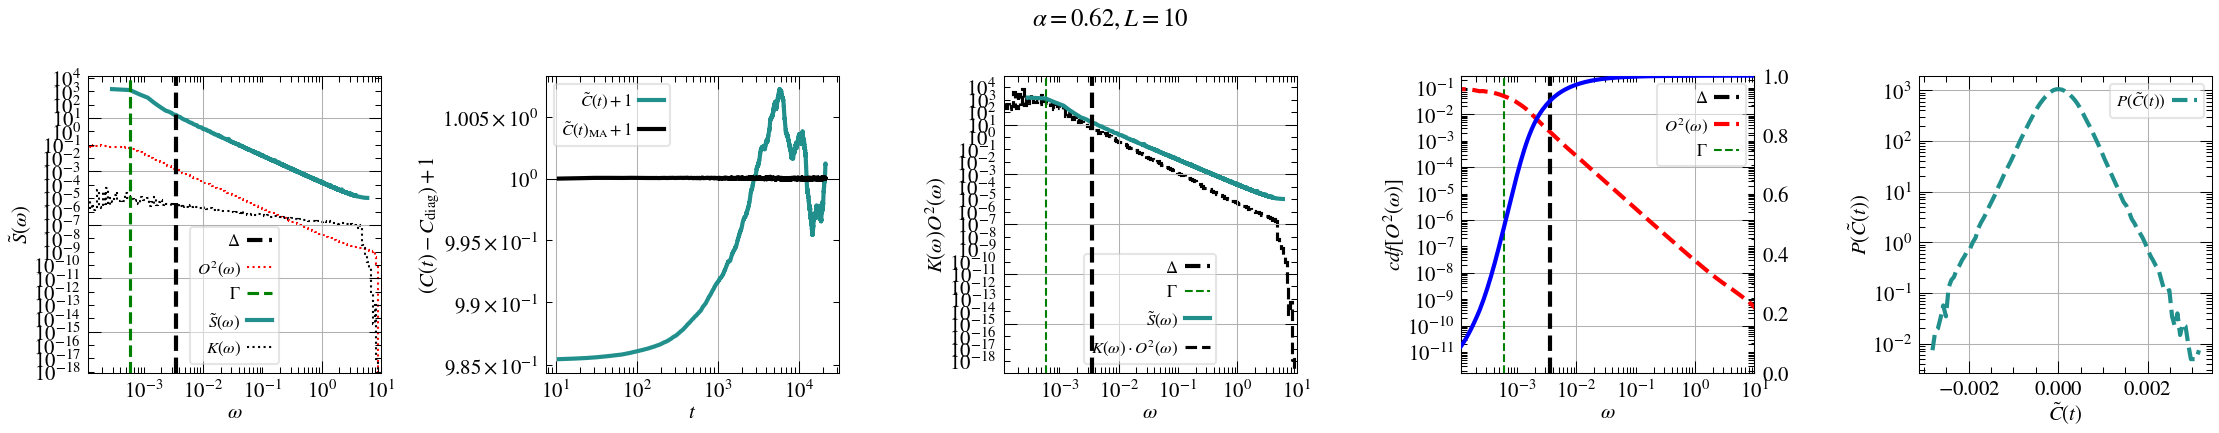

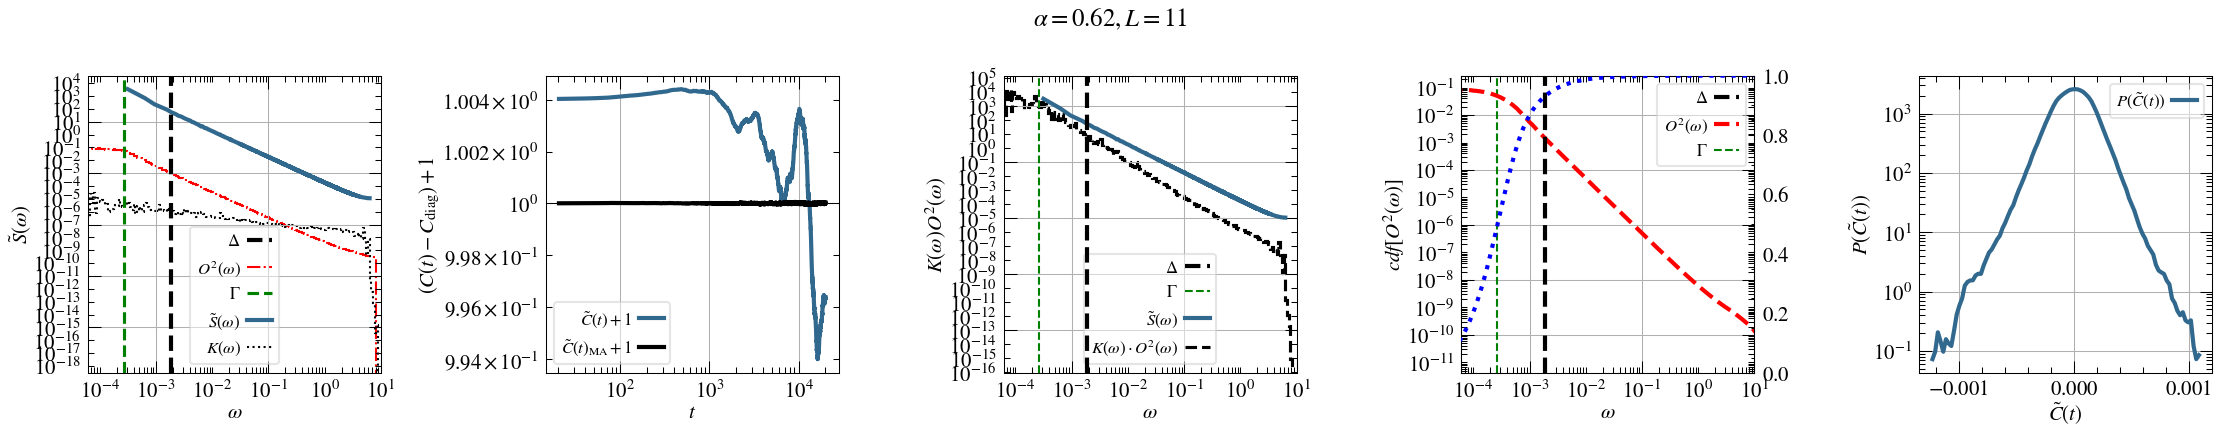

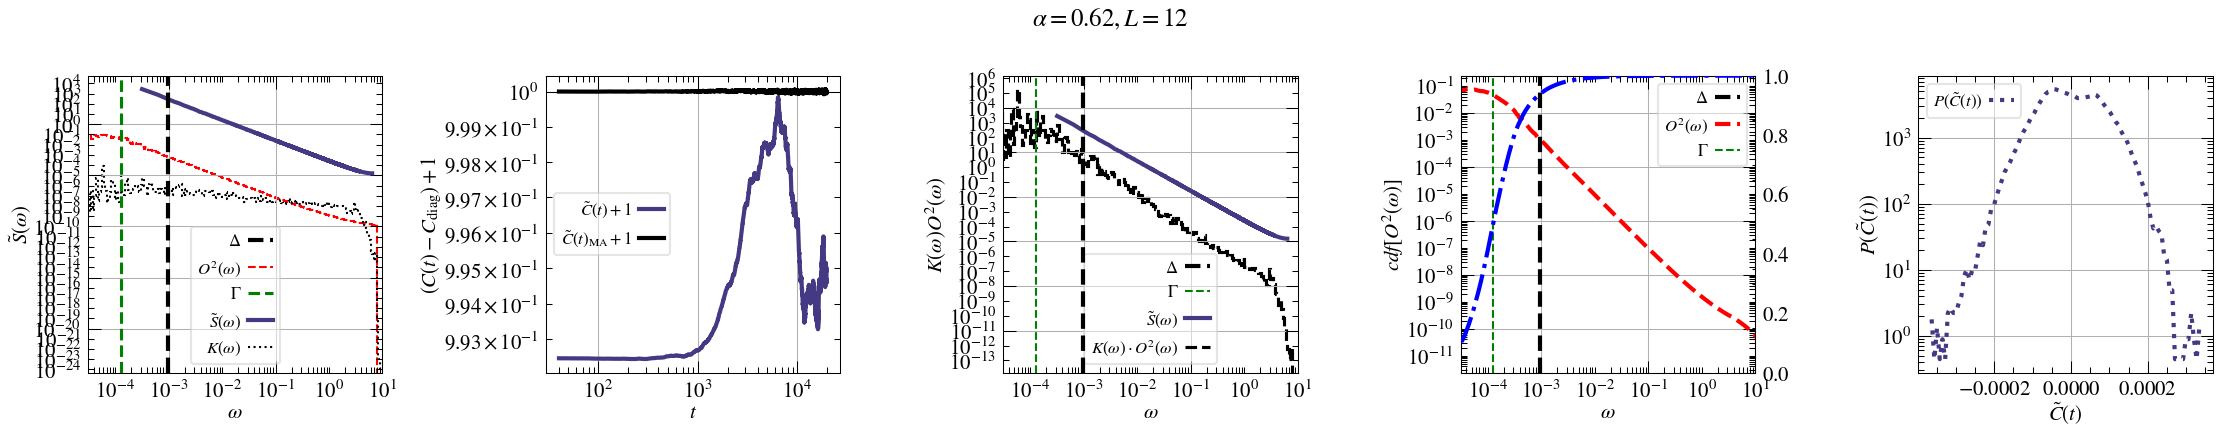

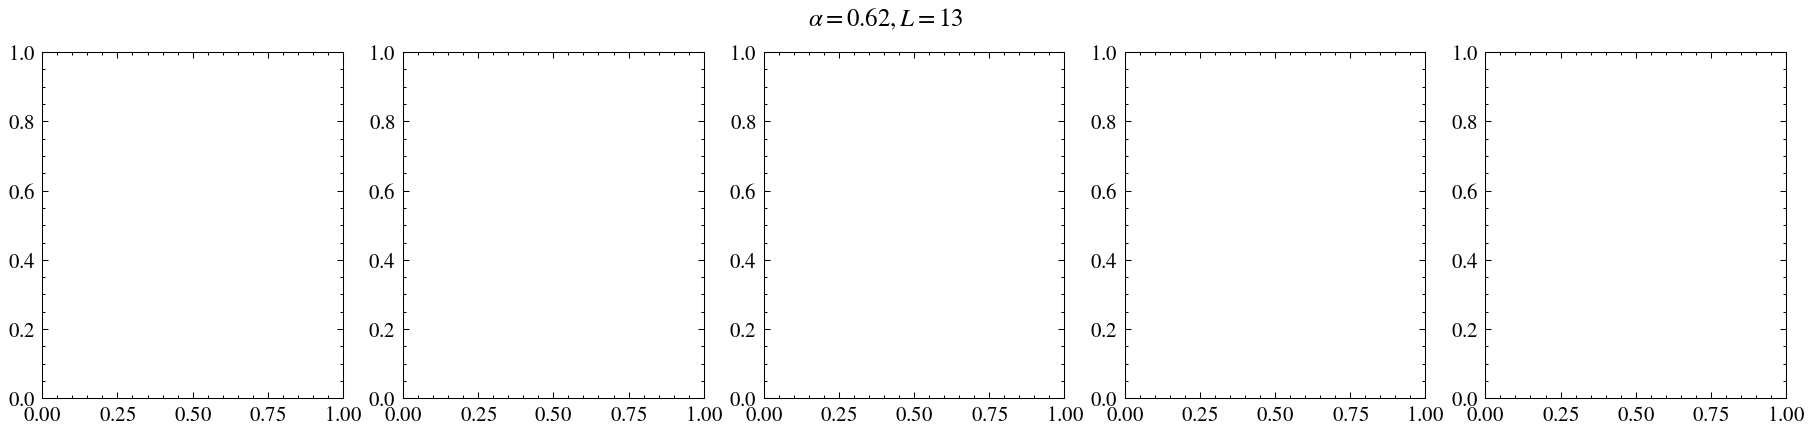

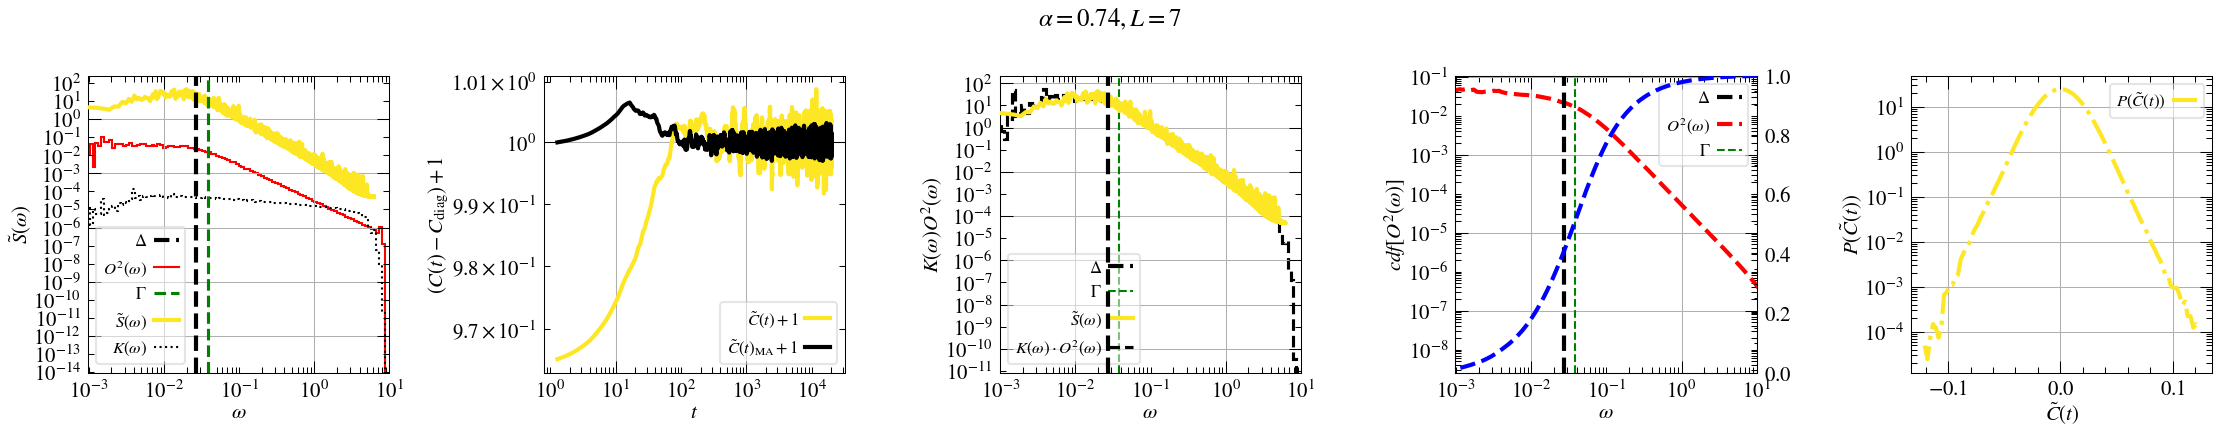

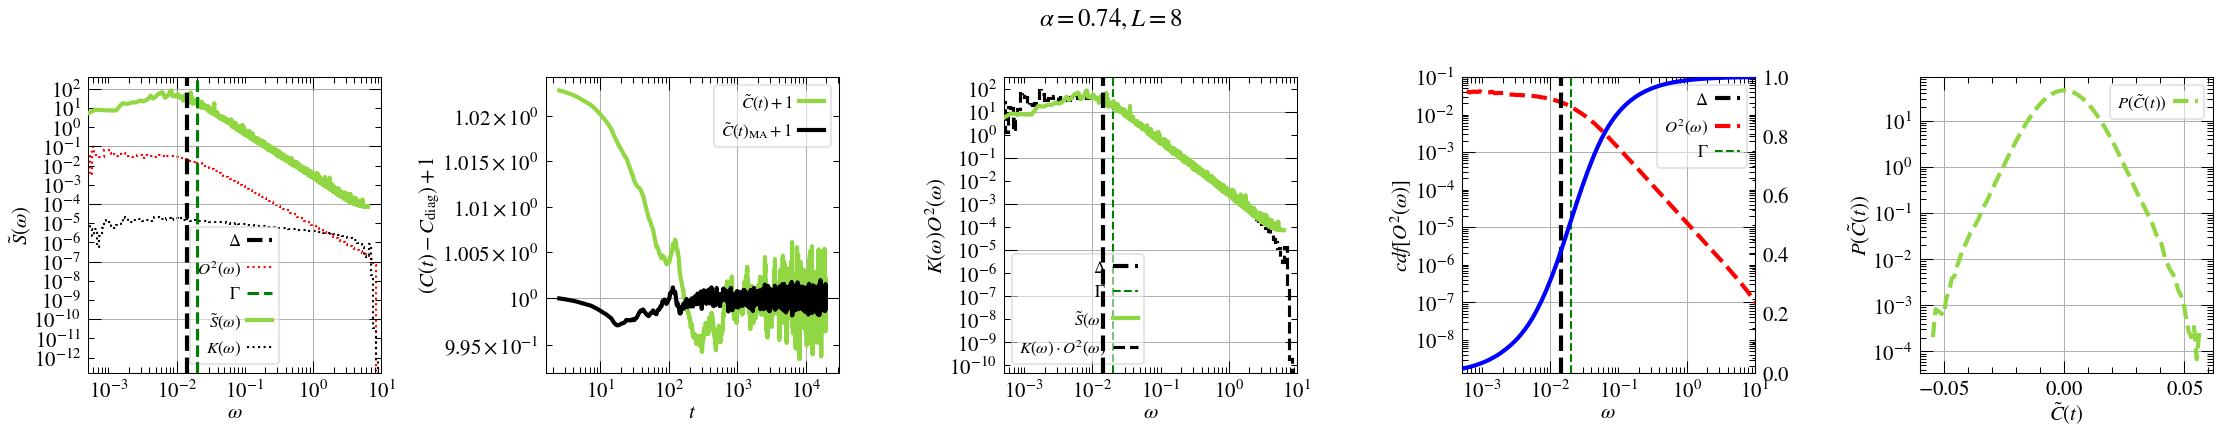

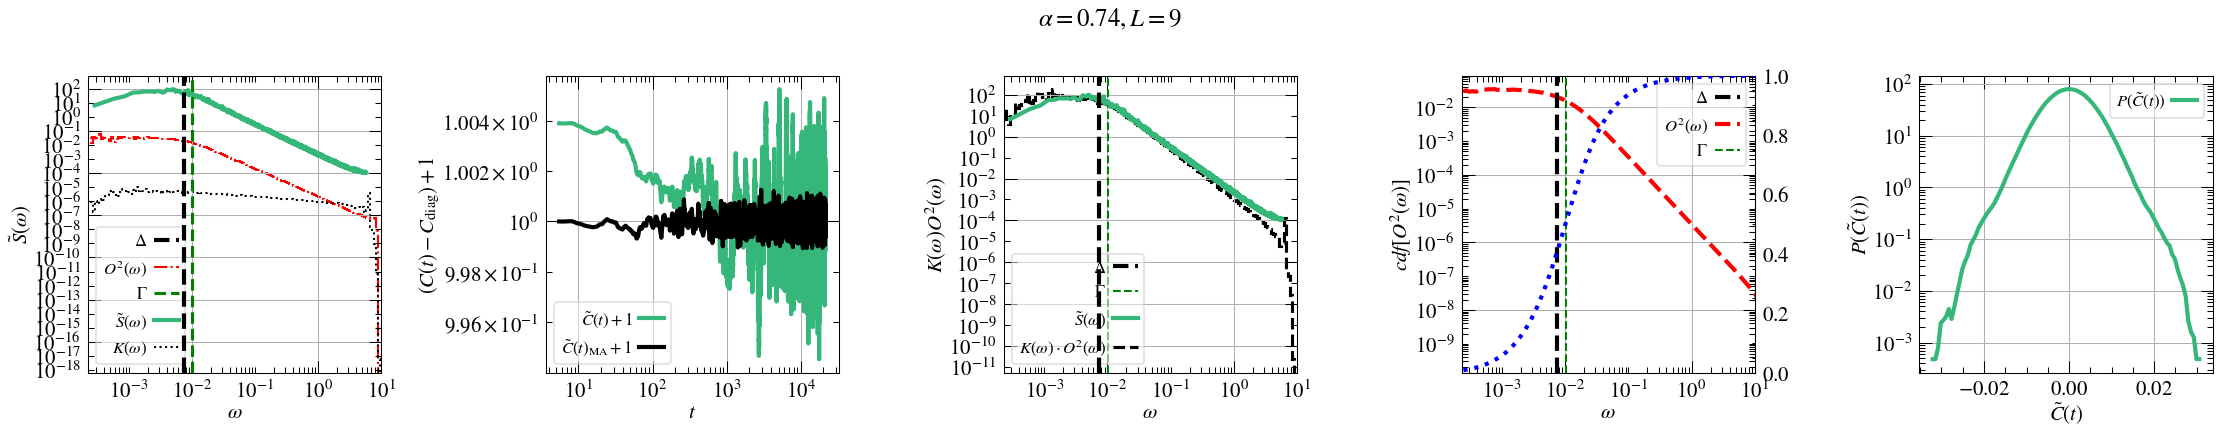

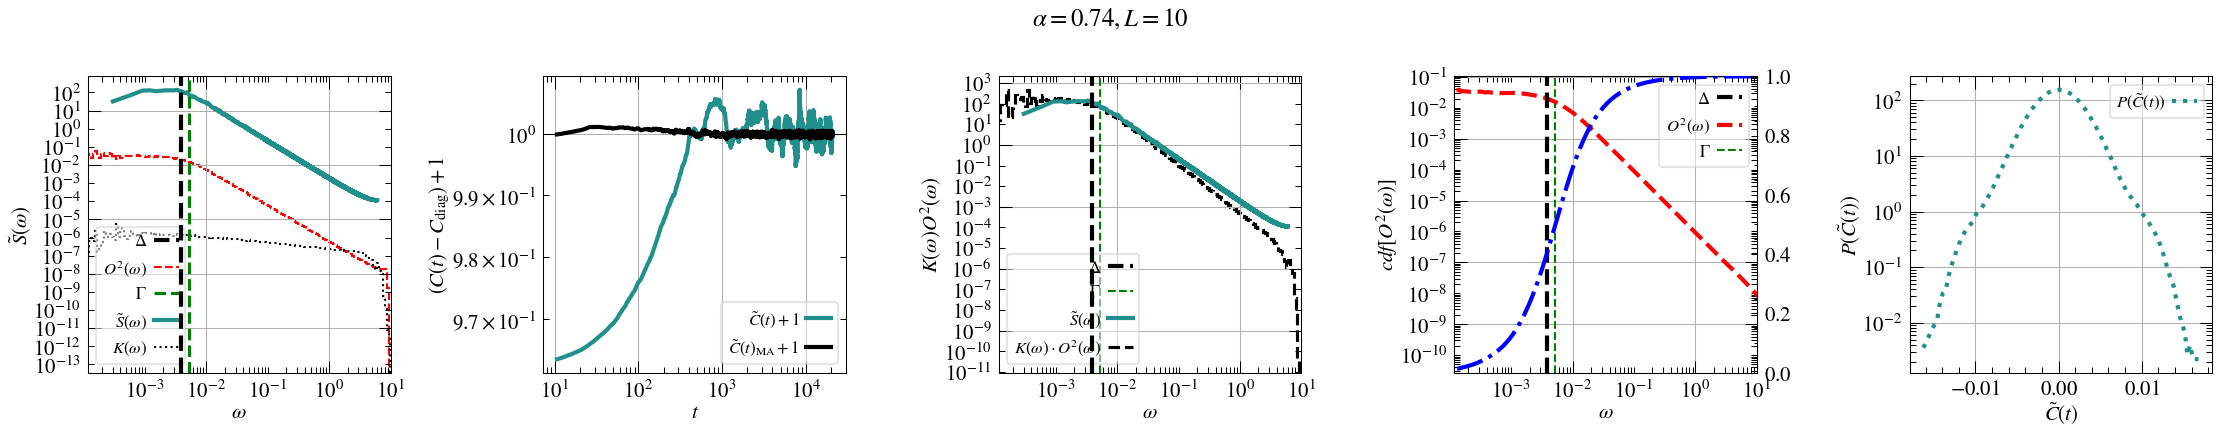

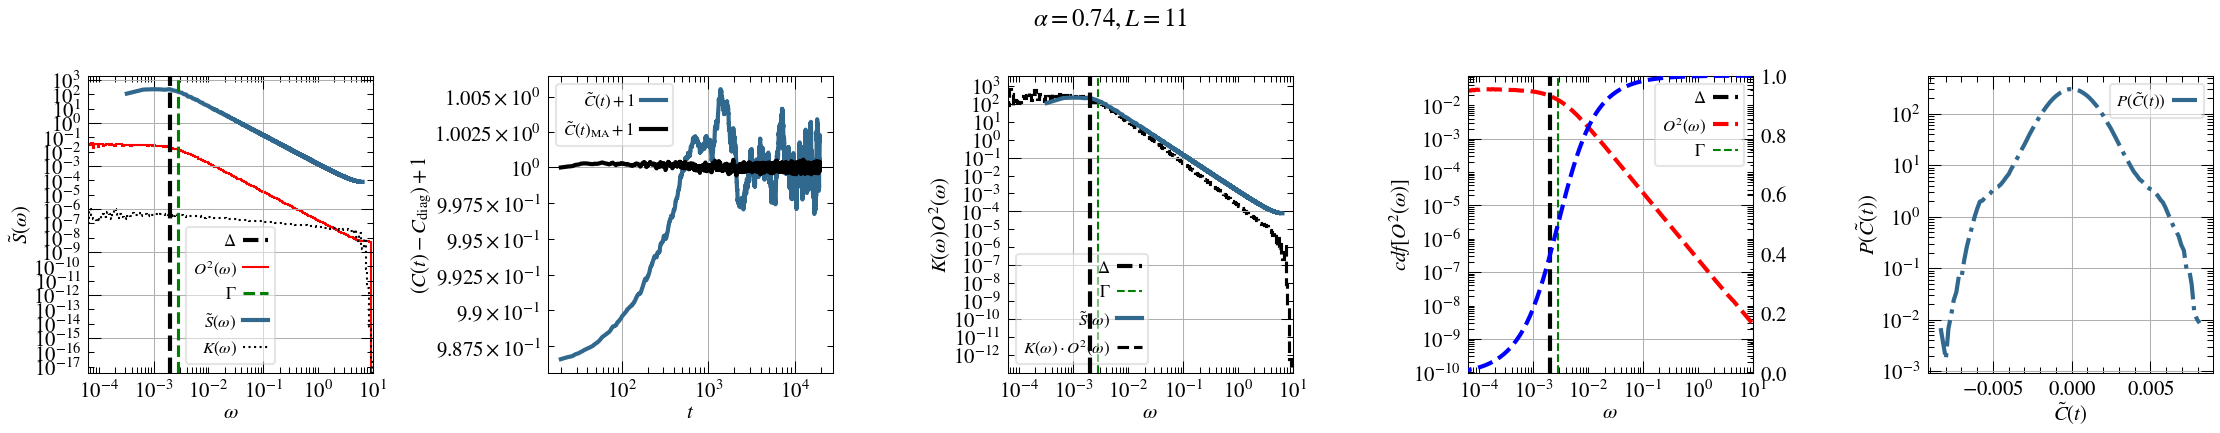

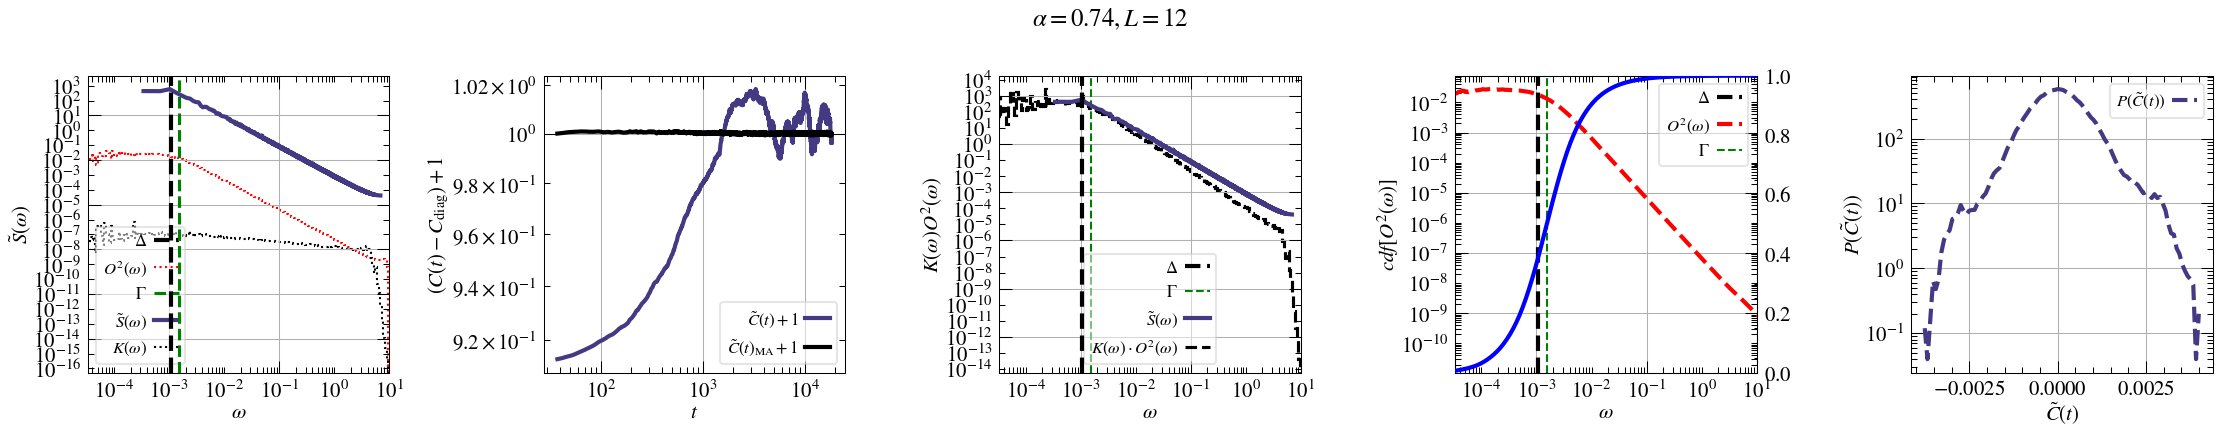

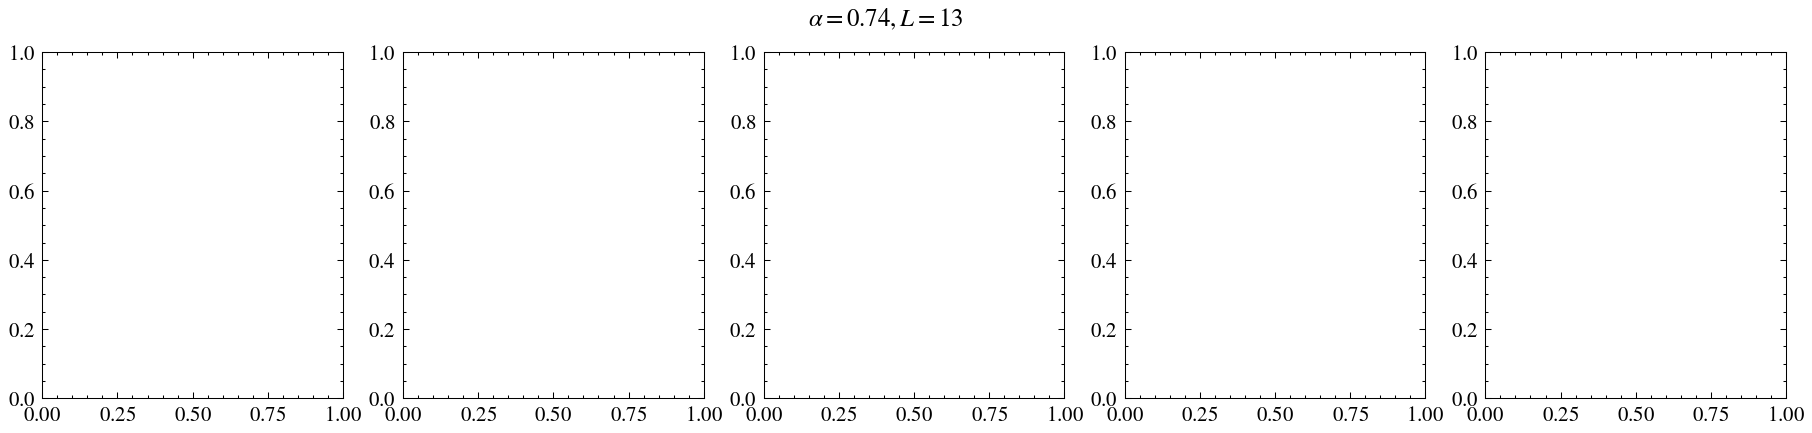

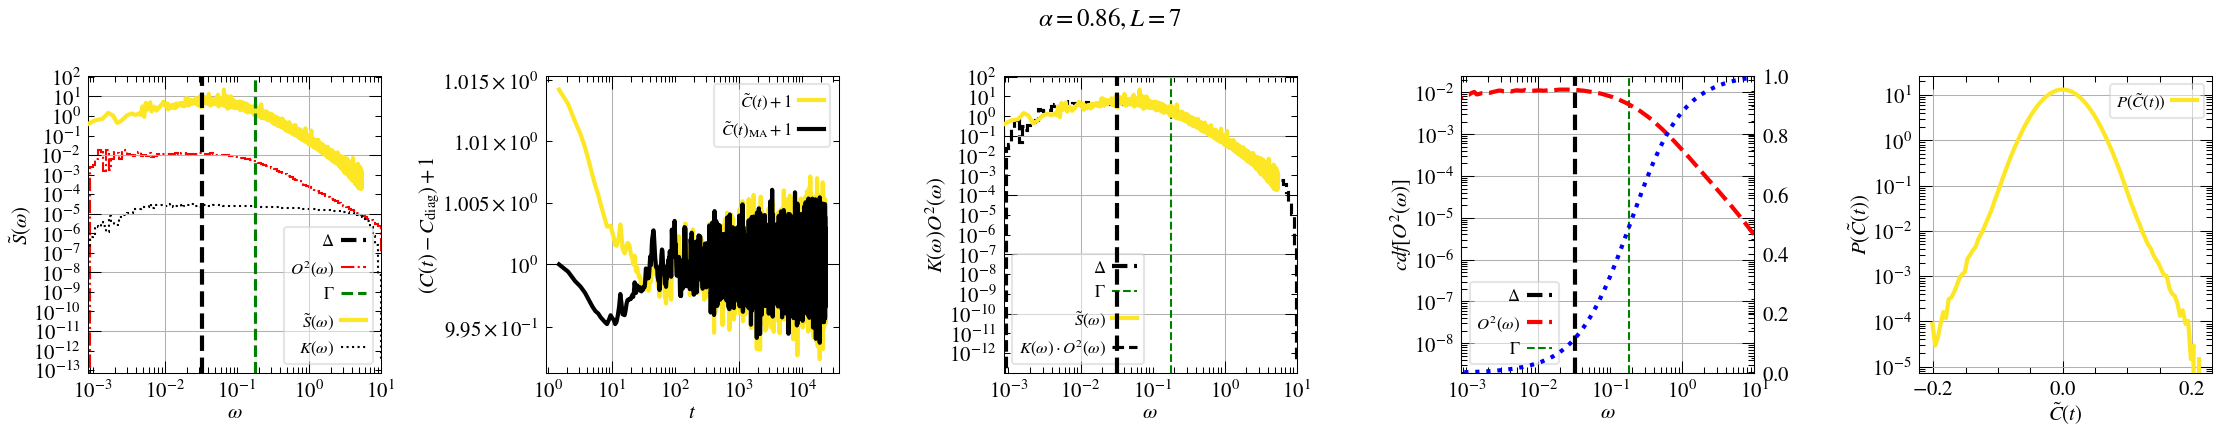

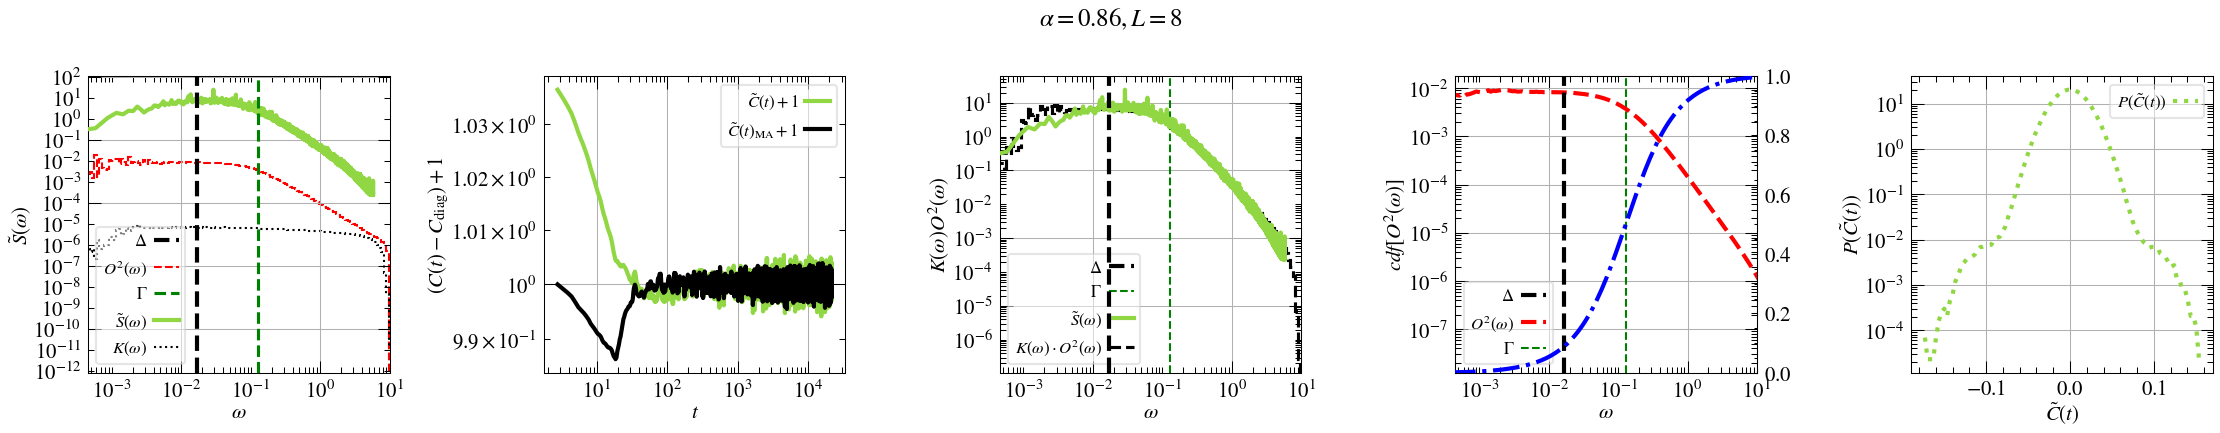

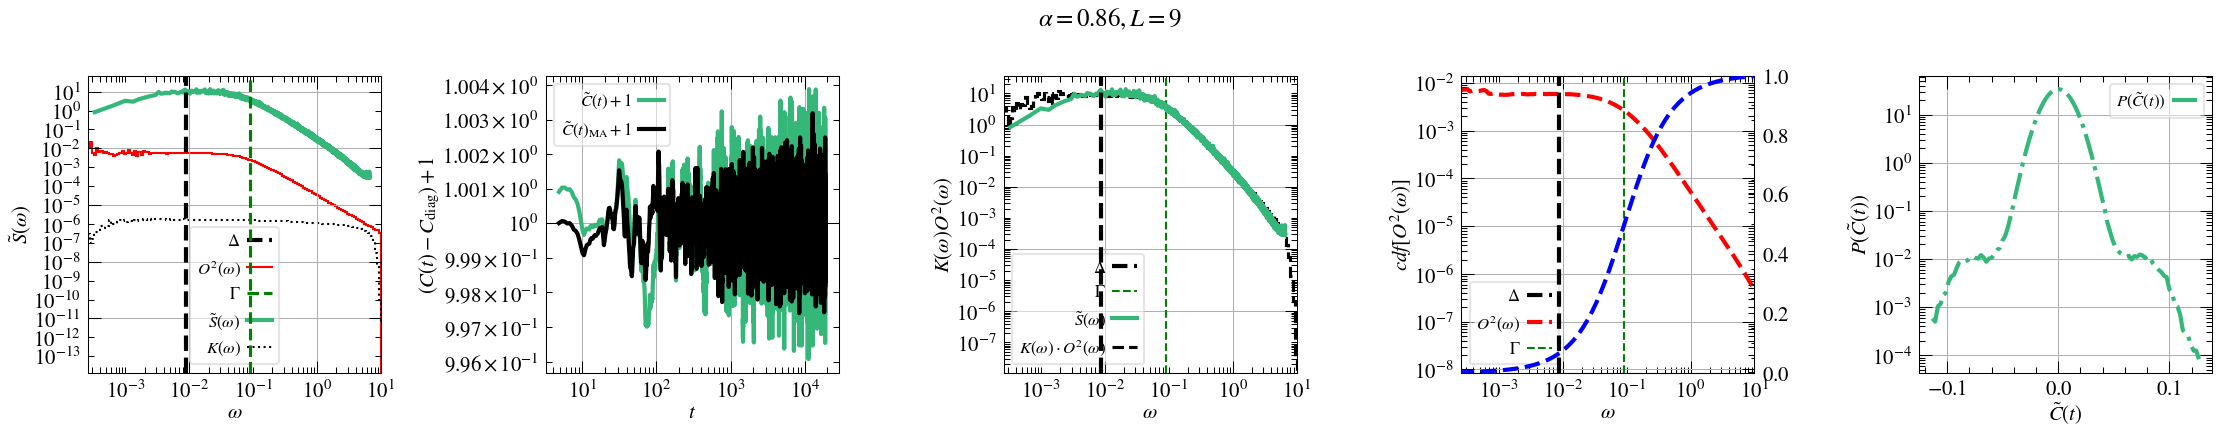

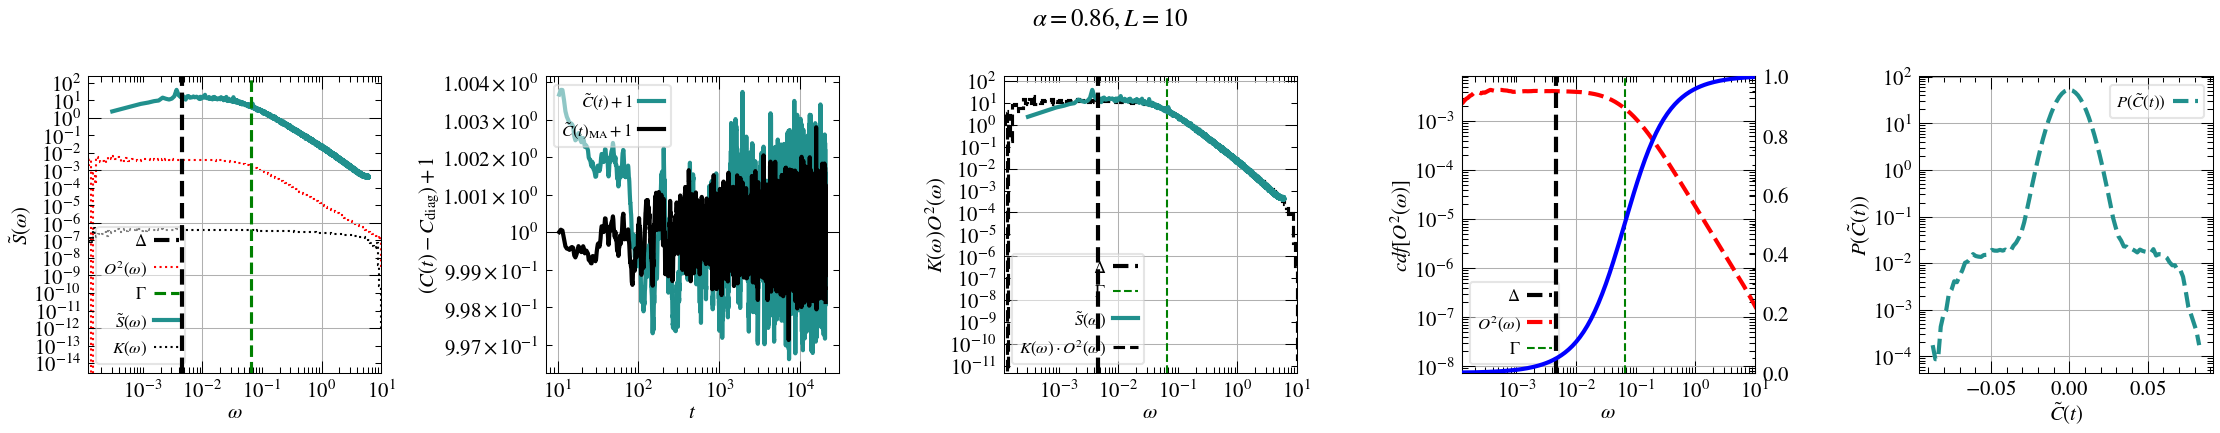

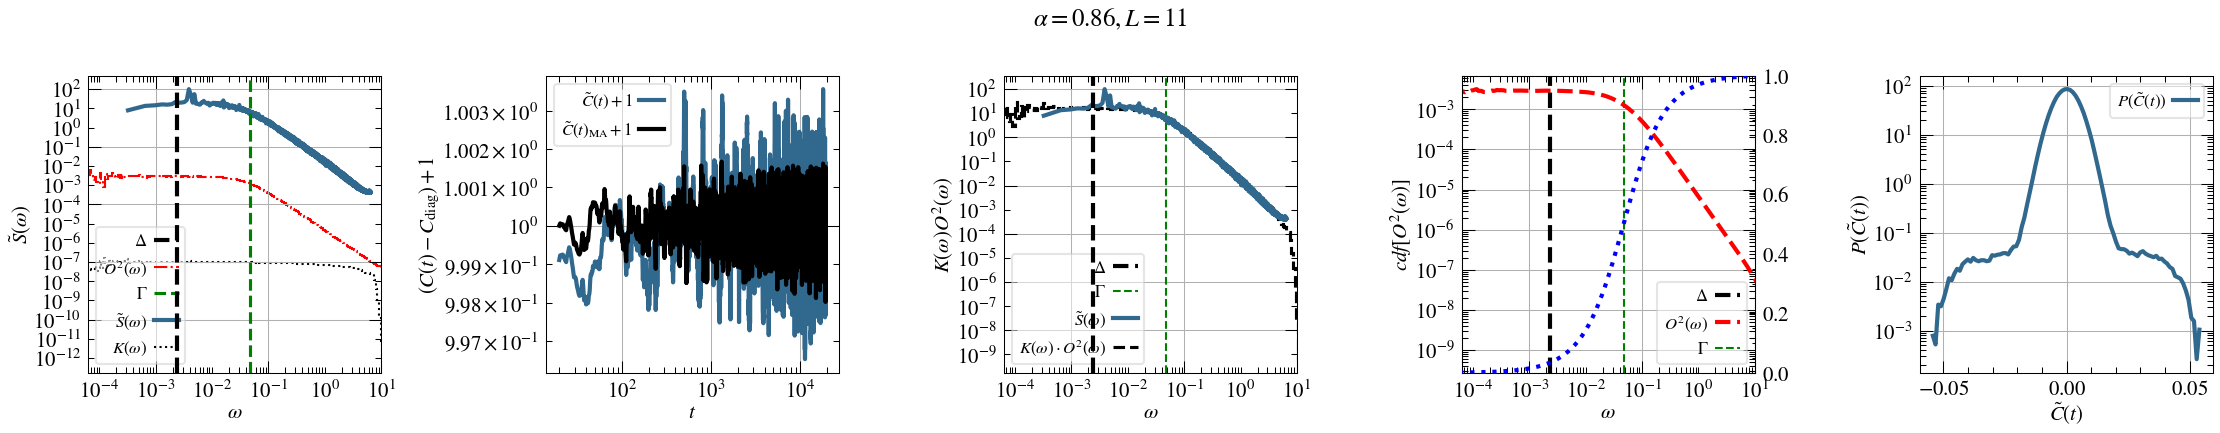

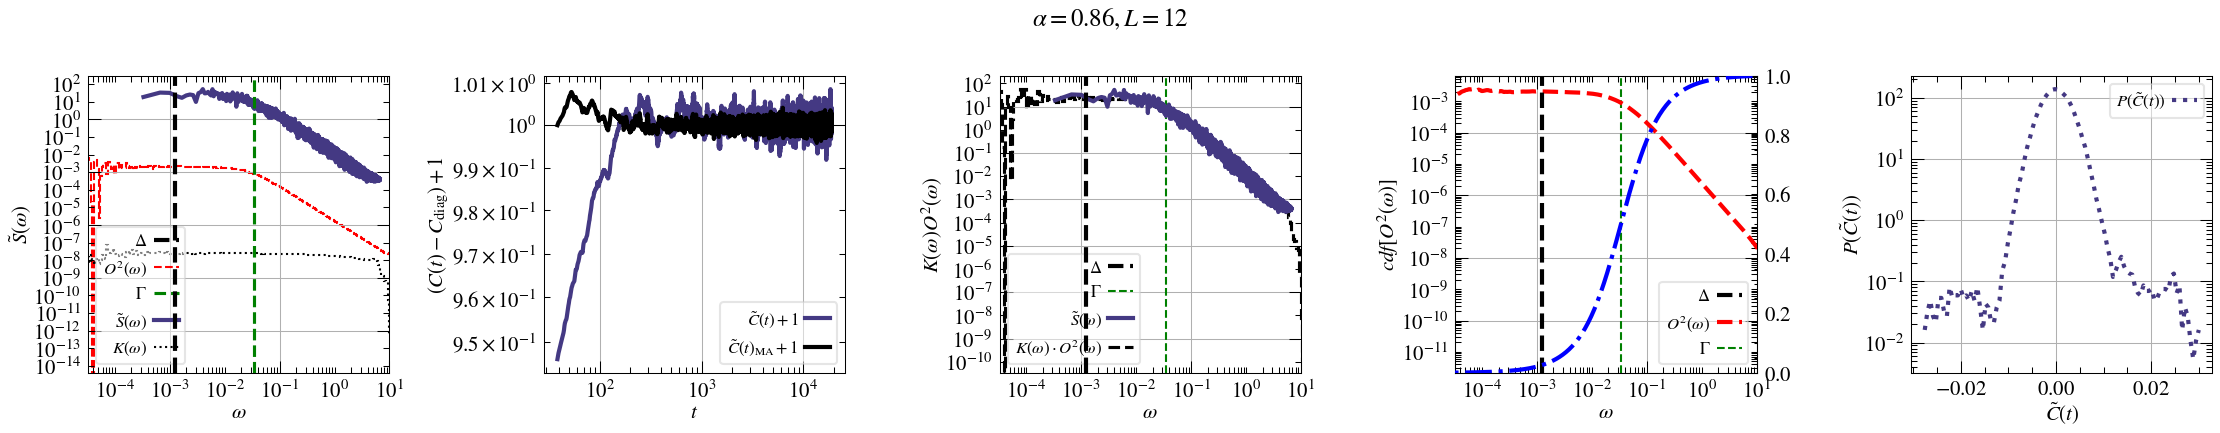

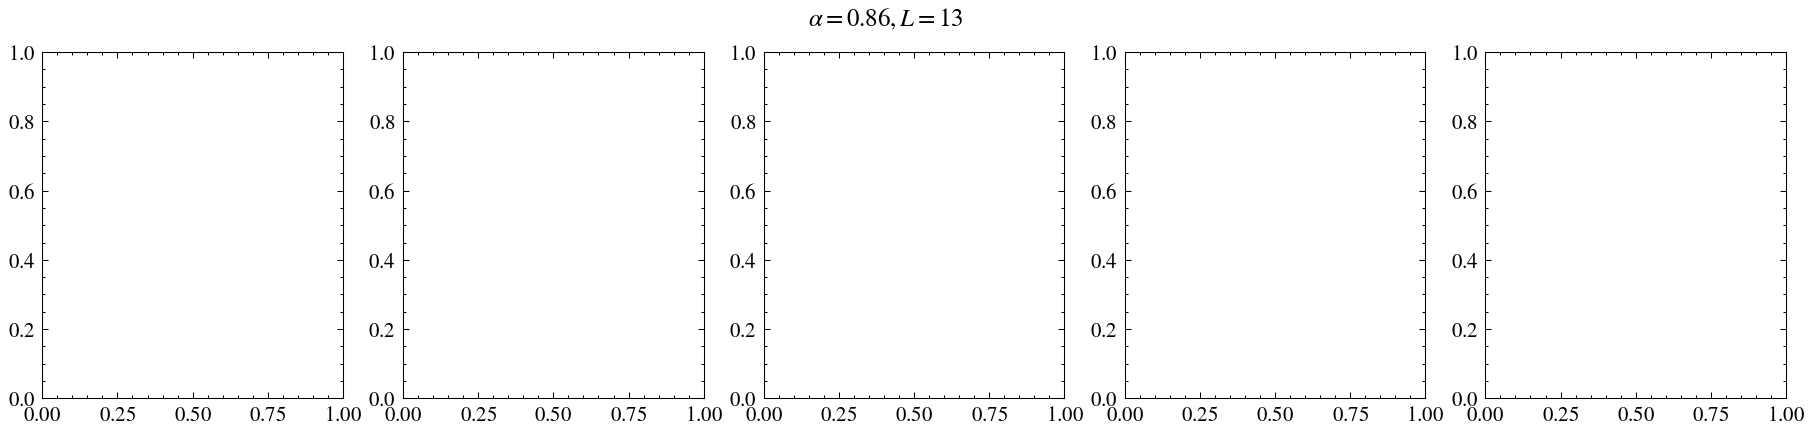

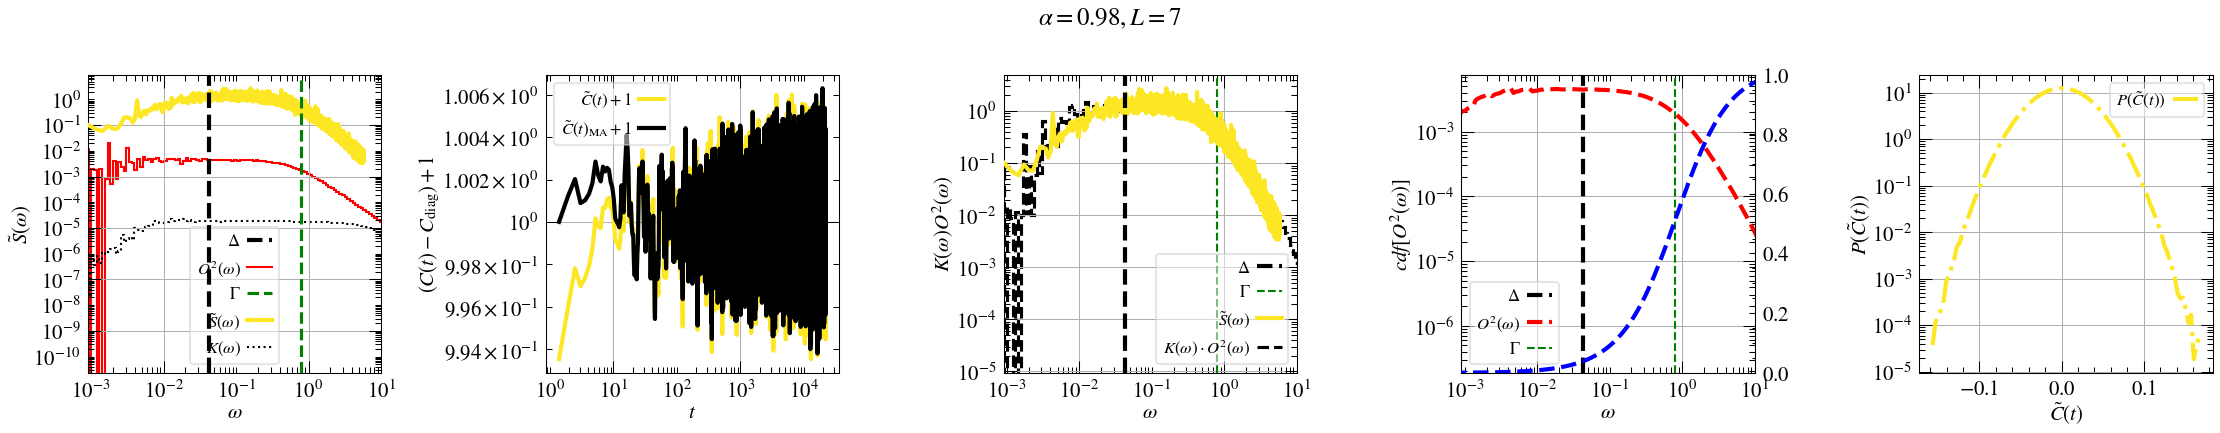

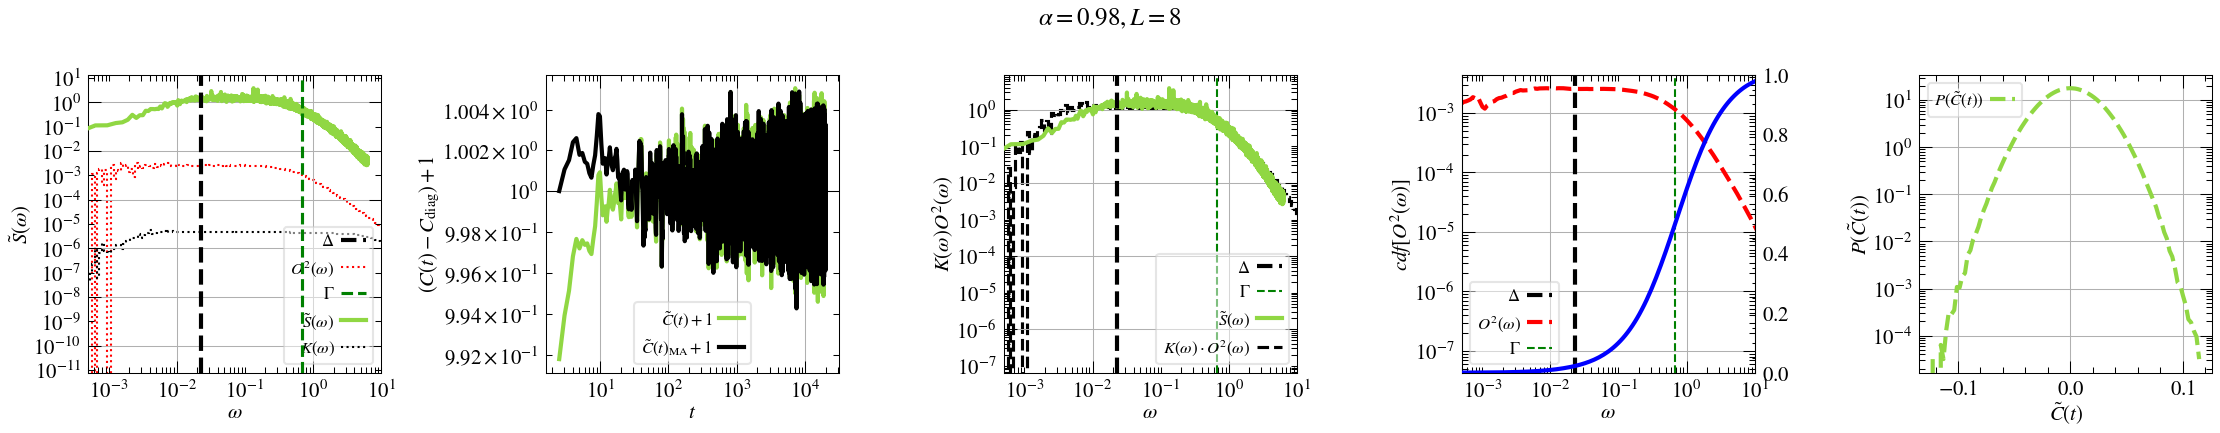

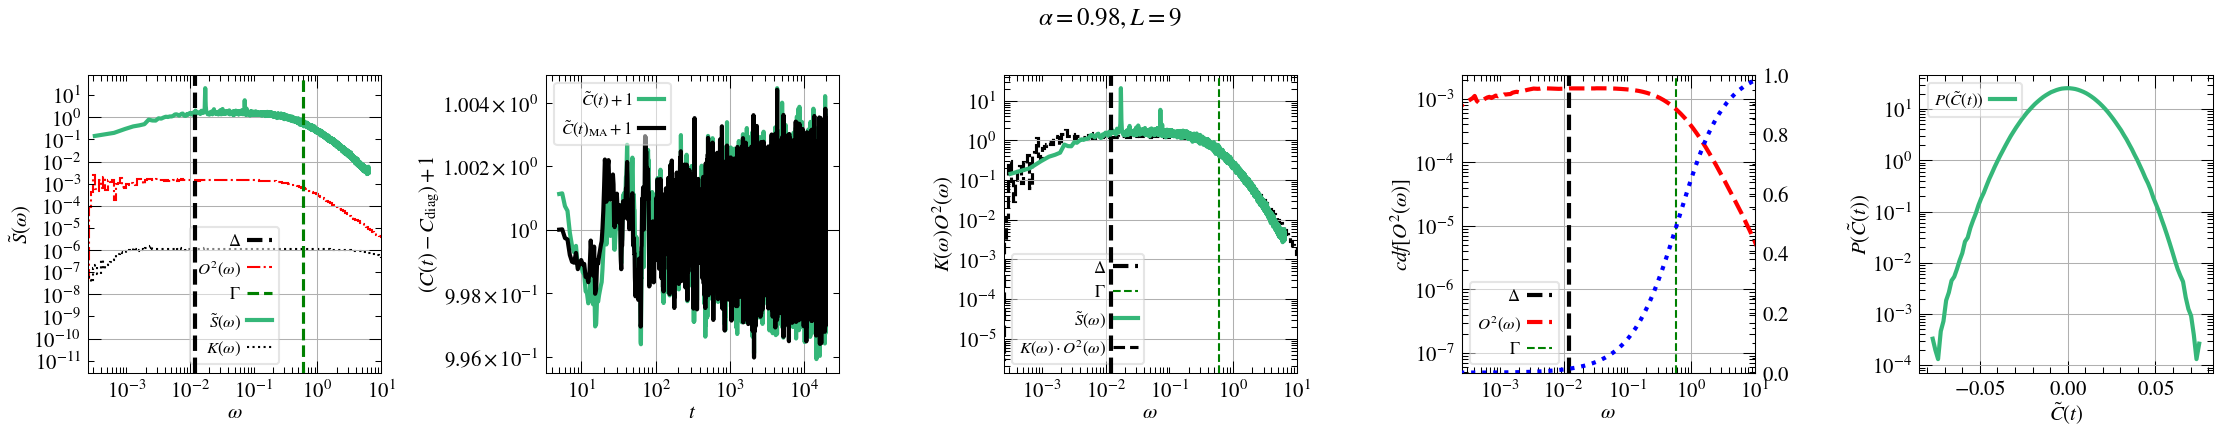

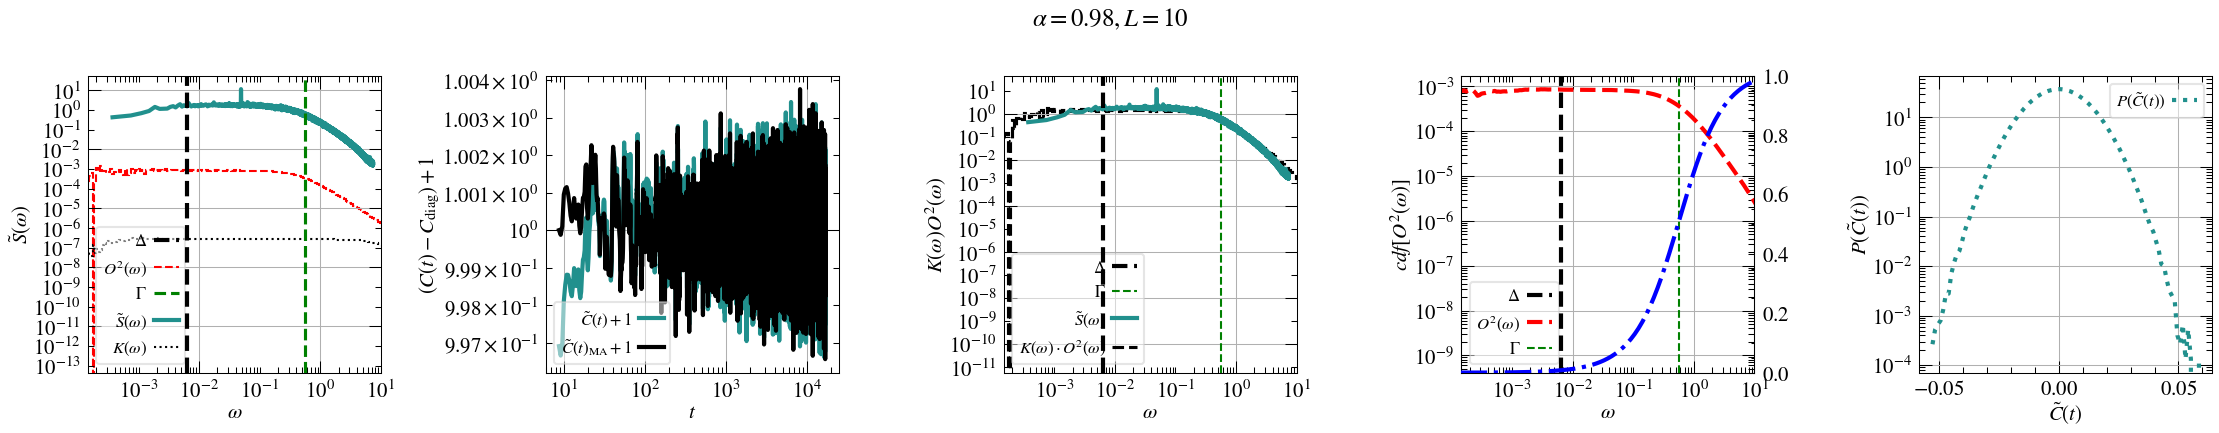

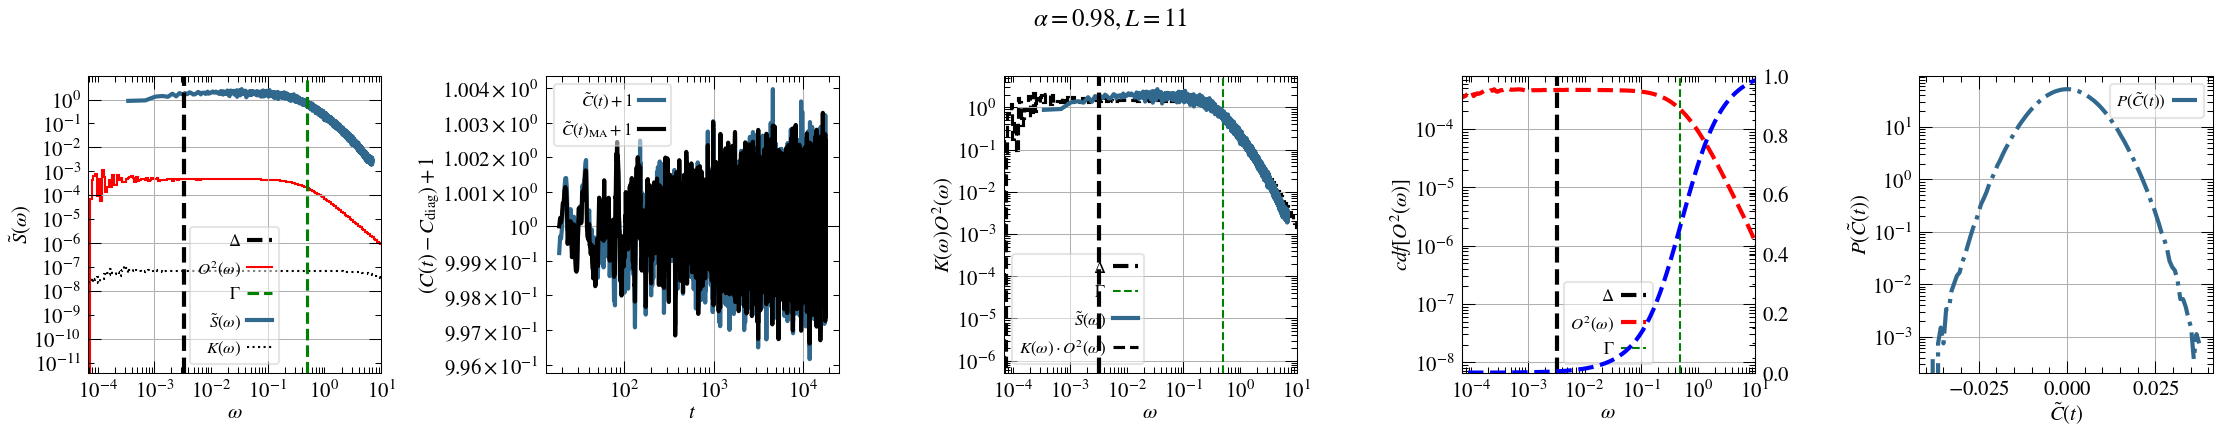

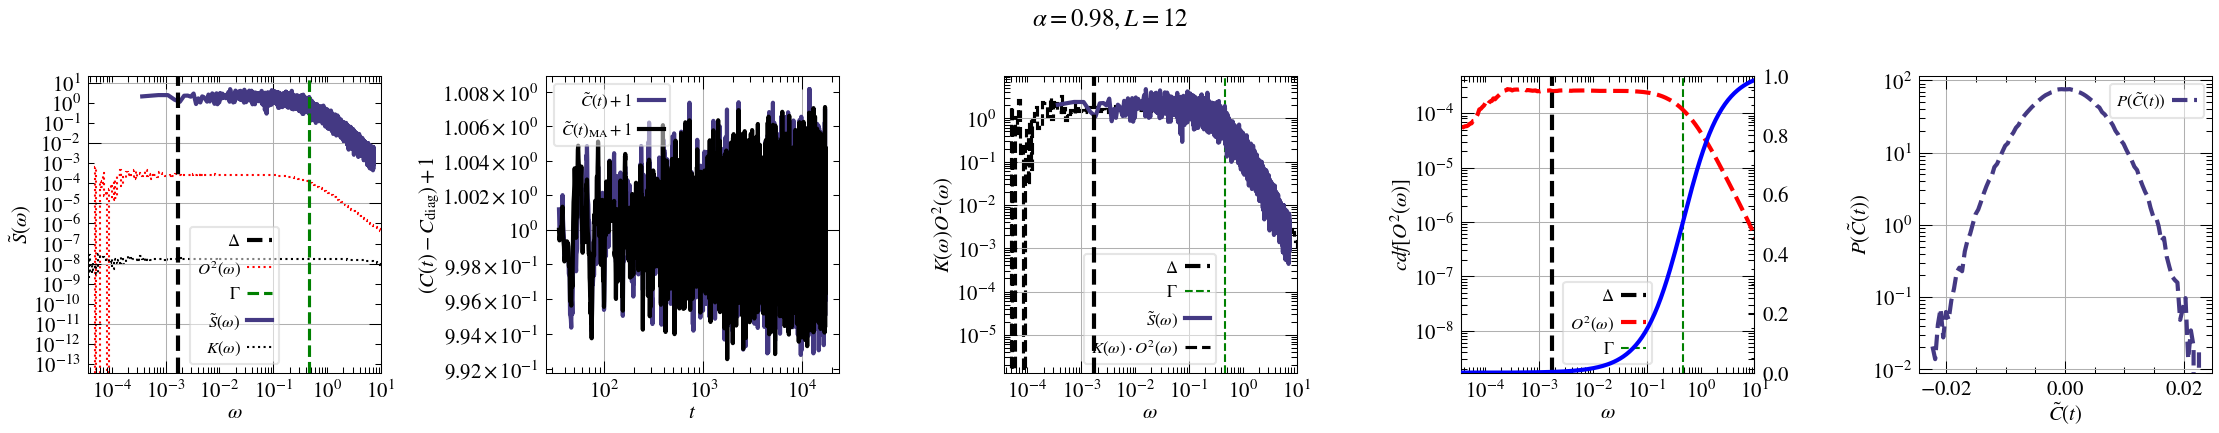

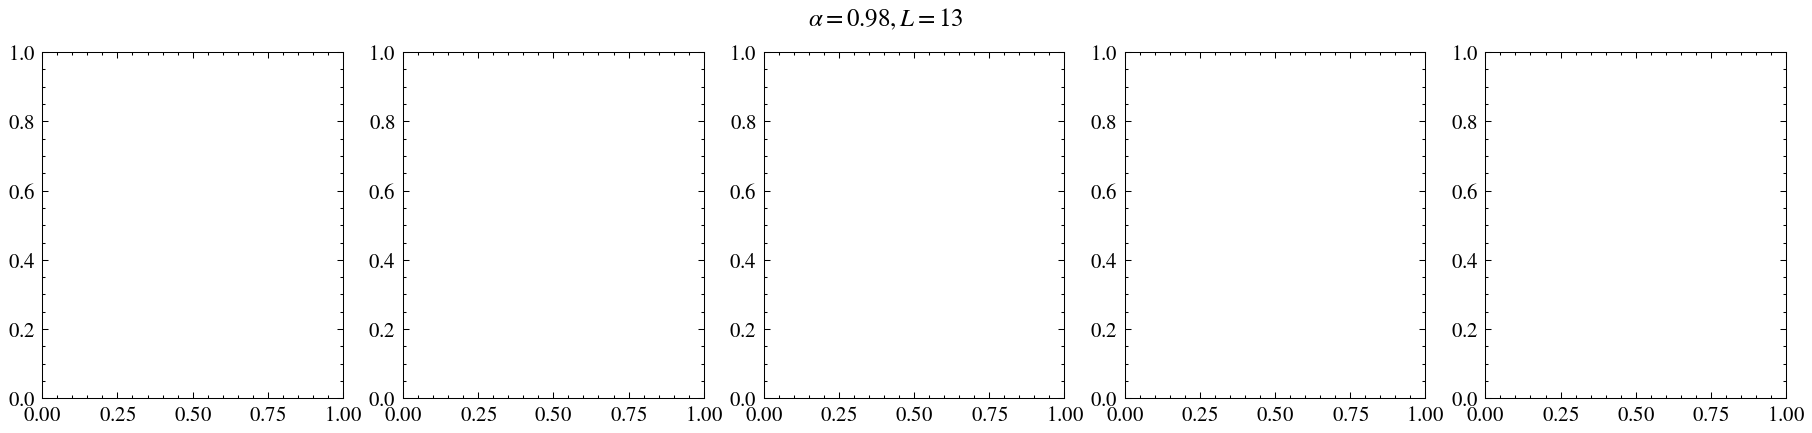

In [7]:
alphas          = np.arange(0.62, 1.0, 0.12)
sites           = np.arange(8, 15, dtype=int)
# sites           = np.arange(9, 10, dtype=int)
n               = 1

directory_s     = Directories(os.curdir, 'data_add', 'uniform', 'processed')
for alpha in alphas:
    for ns in sites:
        y = get_results_single(
            direct   = data_dir,
            alpha    = alpha,
            ns       = ns,
            n        = n,
            uniform  = True)
        HDF5Manager.save_data_to_file(directory=directory_s, filename = f'alpha_{alpha:.2f}_ns_{ns}_n_{n}.h5', data_to_save=y)
        plt.savefig(directory_s / f'alpha_{alpha:.2f}_ns_{ns}_n_{n}.png', dpi=150)
        plt.savefig(directory_s / f'alpha_{alpha:.2f}_ns_{ns}_n_{n}.pdf', dpi=150)